In [141]:
%reload_ext autoreload
%autoreload 2

%gui qt

import numpy as np
import numba as nb
import scipy as sp
import matplotlib as mpl
import matplotlib.pyplot as plt
from tqdm import tqdm
import time
import napari
from pathlib import Path
import vrExperiment as vre
import vrFunctions as vrf
import basicFunctions as bf
import uiPlottingFunctions as uipf
import redCellGUI as rgui

In [64]:
# Code Needs: (eventually)
# - ROICaT index alignment tools (will wait until I have data processed and loaded from multiple sessions)

In [3]:
# Immediate next steps for programming work:

# - red cell processing functions
# - database development


In [16]:
mouseName = 'ATL020'
dateString = '2023-05-04'
session = '702'

In [2]:
mouseName = 'CR_Hippocannula6'
dateString = '2022-09-05'
session = '701'

# Test vrRegistration for CR_Hippocannula6
# vrReg = vre.vrExperimentRegistration(mouseName, dateString, session, oasis=False, imaging=True)

# vrReg.processTimeline()
# # vrReg.processBehavior()
# vrReg.processImaging()
# vrReg.processFacecam()
# # vrReg.processBehavior2Imaging()

# vrReg.saveParams()

In [6]:
# vrExperiment registration and preprocessing 
vrReg = vre.vrExperimentRegistration(mouseName, dateString, session, oasis=False, imaging=True)
vrReg.doPreprocessing()
vrReg.saveParams()
print(vrReg.sessionPath())
del vrReg

In session: ATL020/2023-05-04/702, vrFile['rigInfo'] does not exist. Assuming default settings for B2!
Self.value['numTrials'] set by trialInfo.trialIdx>0, but this might not be right. There might be smarter ways to determine which trials are 'good' trials...
frame2time had 2 more than suite2p output. This happens sometimes. I don't like it. I think it's because scanimage sends a TTL before starting the frame
Convert mpciROIs.planeIndex to mpciROIs.stackPosition, with [X,Y,Z(planeIndex)] coordinate for each ROI!
Facecam preprocessing has not been coded yet!
C:\Users\andrew\Documents\localData\ATL020\2023-05-04\702


In [3]:
# Load registered vrExperiment
vrexp = vre.vrExperiment(mouseName, dateString, session)

In [13]:
%%time
speedThreshold = 5
omap, smap, lickmap, distvec = vrf.getBehaviorMaps(vrexp,speedThreshold=speedThreshold) # produce smoothed occupancy and speed maps, along with the distance bins used to create them
frameTrialIdx, framePosition, frameSpeed = vrexp.getFrameBehavior() # convert behavioral data into timeframe of spiking data
spkmap = vrf.getSpikeMap(vrexp, frameTrialIdx, framePosition, frameSpeed, distvec, omap, speedThreshold=speedThreshold, standardizeSpks=False, doSmoothing=0) # produce the spkmap 
idxFullTrials = np.all(~np.isnan(omap),axis=1) # find out which trials the mouse explored the whole environment
relmse, relcor = vrf.measureReliability(spkmap[:,idxFullTrials], numcv=3) # measure reliability of spiking
spInfo = vrf.measureSpatialInformation(omap[idxFullTrials], spkmap[:,idxFullTrials]) # measure spatial information of spiking

CPU times: total: 3.58 s
Wall time: 512 ms


In [61]:
# red curation pipeline:
# write custom class for handling red data (maybe as part of vrExperiment?) -- (input is vrExp)
# write GUI function that opens the red handler -- (input is vrExp, creates the reddata object and a GUI)
# the GUI will then communicate between the user and the red cell handler!

# plan of attack: 
# - first, start with napari style GUI where reference image is overlaid by all ROIs that meet red cell criterion
# -------- use the four metrics, use double infinite lines to define the minimum and maximum value tolerated for red cells
# -------- never use grid mode...
# -------- create button to save selection criterion and classification output for each session independently

# - second, build scrollMatchedImages style GUI with a few extra selections... probably using a Qt Gui application rather than a pyqtgraph layout
# --------- for this, go through each ROI and optionally add manual annotation, which can be saved independently
# --------- it'll be nice to have mechanisms to choose which ROIs to look through, e.g. (1) in order red probability, (2) only red, (3) only ones with manual annotations, (4) etc.... 

# ---
# ---  
# ---
# immediate next steps: 
# 1. -----finished----- write "computeDot"
# 2. -----finished----- write "computeCorr"
# -- -----finished----- using the quick scrollMatchedImages GUI, compare results from CR6 in matlab and python --
# 3. build napari interface
# 4. play with settings, probably try to integrate filter selection and correlation radius selection into the GUI

In [60]:
vrexp = vre.vrExperiment(mouseName, dateString, session)
redCell = vre.redCellProcessing(vrexp)

planeIdx=0
redS2P = redCell.redS2P[redCell.roiPlaneIdx==planeIdx]
idxRedS2P = np.arange(len(redS2P))
# idxRedS2P = np.argsort(redS2P)[::-1]

refStack, maskStack, pxcStack, pxcCenter = redCell.croppedPhaseCorrelation(planeIdx=planeIdx)
window = uipf.scrollMatchedImages((refStack[idxRedS2P], maskStack[idxRedS2P], pxcStack[idxRedS2P]),enableMouse=True,preserveScale=True) 

# compute normalized dot product between mask and filtered reference
%time dprod = redCell.computeDot(planeIdx=planeIdx)
%time ccoef = redCell.computeCorr(planeIdx=planeIdx)

CPU times: total: 141 ms
Wall time: 162 ms
CPU times: total: 500 ms
Wall time: 526 ms


In [66]:
# This code block is helping to develop the redCellGUI.redSelection() GUI interface...
# It shows all the features and all the relevant stacks. Now I need to build the napari interface
features = [redS2P[idxRedS2P], dprod[idxRedS2P], ccoef[idxRedS2P], pxcCenter[idxRedS2P]] 
window = rgui.redCellViewer((refStack[idxRedS2P], maskStack[idxRedS2P], pxcStack[idxRedS2P]),features,enableMouse=True,preserveScale=True) 

In [147]:
# --- important note!!!!! ---
# the histogram management isn't working correctly...
# ---------------------------


# -- generic optimization --
# 1. speed up feature computation (I really need to make computeDot/computeCorr/computePhaseCorrelation as fast as possible...)
# 2. ... 

# -- next steps --
# then, add some key bindings (and eventually buttons) for switching modes regarding how the labels are colored (heatmap based on a selected feature, for example)
# also need to add mechanism for clicking on ROIs and manually adjusting whether they are "RED" or not
# (manual selection can also be another criterion for how to color them -- it's own setting independent of random or feature heatmap)

# -- key bindings and additional functionality --
# tab to change which coloring mechanism is used for the label, including one coloring method where the scaled pixel values are shown in the same color as an image layer...

# -- next steps --
# add the other GUI buttons to the viewer, like "switchPlanes" and "saveRedPrms" and anything else...

# -- further steps --
# see if there's a way to click click on the ROI on the viewer screen and flip it to Red / NotRed

# Codeblock for developing napari viewer for red cell management
vrexp = vre.vrExperiment(mouseName, dateString, session)
redCell = vre.redCellProcessing(vrexp)
redSelection = rgui.redSelectionGUI(redCell)

Processing plane 0 for session CR_Hippocannula6/2022-09-05/701...
Finished in 2.2834434509277344 seconds.
Processing plane 1 for session CR_Hippocannula6/2022-09-05/701...
Finished in 2.293508529663086 seconds.
Processing plane 2 for session CR_Hippocannula6/2022-09-05/701...
Finished in 2.234525203704834 seconds.
Processing plane 3 for session CR_Hippocannula6/2022-09-05/701...
Finished in 2.4351308345794678 seconds.
Processing plane 4 for session CR_Hippocannula6/2022-09-05/701...
Finished in 2.4444854259490967 seconds.


In [149]:
redSelection.initializeNapariViewer()

hello from update colors
hello from update colors
hello from update colors
hello from update colors
plotting Control cells...
plotting Red cells...
plotting Control cells...
plotting Red cells...
plotting Control cells...
plotting Red cells...
plotting Control cells...
plotting Red cells...
plotting Control cells...
plotting Red cells...
plotting Control cells...
plotting Red cells...
plotting Control cells...
plotting Red cells...
1
plotting Control cells...
hello from update colors
plotting Red cells...
hello from update colors
hello from update colors
plotting Control cells...
plotting Red cells...


In [107]:
# possibleColormaps = 'plasma', 'autumn', 'spring', 'summer', 'winter', 'hot'

features = np.arange(10)
colors = plt.colormaps['plasma'](features)
colormap = dict(zip(np.arange(10), colors))

print(colormap)

{0: array([0.267004, 0.004874, 0.329415, 1.      ]), 1: array([0.26851 , 0.009605, 0.335427, 1.      ]), 2: array([0.269944, 0.014625, 0.341379, 1.      ]), 3: array([0.271305, 0.019942, 0.347269, 1.      ]), 4: array([0.272594, 0.025563, 0.353093, 1.      ]), 5: array([0.273809, 0.031497, 0.358853, 1.      ]), 6: array([0.274952, 0.037752, 0.364543, 1.      ]), 7: array([0.276022, 0.044167, 0.370164, 1.      ]), 8: array([0.277018, 0.050344, 0.375715, 1.      ]), 9: array([0.277941, 0.056324, 0.381191, 1.      ])}


In [144]:
norm = mpl.colors.Normalize(vmin=-1, vmax=1)
colors = plt.colormaps['hot'](norm(np.arange(10)))
colors

array([[1.       , 0.3593141, 0.       , 1.       ],
       [1.       , 1.       , 1.       , 1.       ],
       [1.       , 1.       , 1.       , 1.       ],
       [1.       , 1.       , 1.       , 1.       ],
       [1.       , 1.       , 1.       , 1.       ],
       [1.       , 1.       , 1.       , 1.       ],
       [1.       , 1.       , 1.       , 1.       ],
       [1.       , 1.       , 1.       , 1.       ],
       [1.       , 1.       , 1.       , 1.       ],
       [1.       , 1.       , 1.       , 1.       ]])

In [159]:
planeIdx = 2
%time x1 = redCell.redS2P[redCell.roiPlaneIdx==planeIdx]
%time x2 = redCell.computeDot(planeIdx=planeIdx)
%time x3 = redCell.computeCorr(planeIdx=planeIdx)
%time x4 = redCell.croppedPhaseCorrelation(planeIdx=planeIdx)[3]

CPU times: total: 0 ns
Wall time: 0 ns
CPU times: total: 156 ms
Wall time: 157 ms
CPU times: total: 484 ms
Wall time: 478 ms
CPU times: total: 1.67 s
Wall time: 1.68 s


CPU times: total: 0 ns
Wall time: 9.97 ms
CPU times: total: 3.94 s
Wall time: 3.93 s
CPU times: total: 15.6 ms
Wall time: 18.9 ms


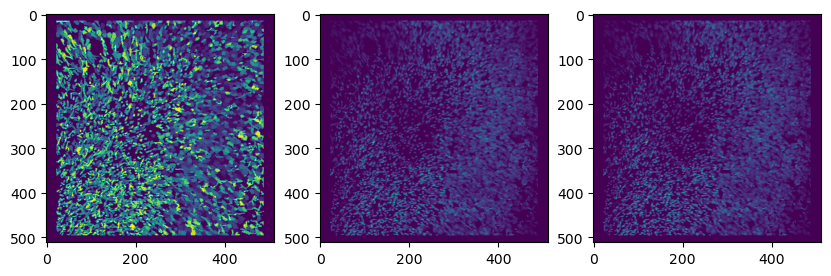

In [103]:
# if planeIdx is None: planeIdx = np.arange(self.numPlanes)
# if isinstance(planeIdx,(int,np.integer)): planeIdx=(planeIdx,) # make it iterable
# assert all([0<=plane<self.numPlanes for plane in planeIdx]), f"in session: {self.sessionPrint()}, there are only {self.numPlanes} planes!"
# roiMaskVolume = []
# for plane in planeIdx:
#     roiMaskVolume.append(np.zeros((self.value['roiPerPlane'][plane],self.lx,self.ly)))
#     idxRoiInPlane = np.where(self.roiPlaneIdx==plane)[0]
#     for roi in range(self.value['roiPerPlane'][plane]):
#         cRoiIdx = idxRoiInPlane[roi]
#         roiMaskVolume[-1][roi,self.ypix[cRoiIdx],self.xpix[cRoiIdx]]=self.lam[cRoiIdx]
# return np.concatenate(roiMaskVolume,axis=0)    

def createLabels():
    planeIdx = 0
    labelLayer = np.zeros((redCell.ly,redCell.lx))
    idxRoiInPlane = np.where(redCell.roiPlaneIdx==planeIdx)[0]
    for idx,roi in enumerate(idxRoiInPlane):
        labelLayer[redCell.ypix[roi],redCell.xpix[roi]]=idx
    return labelLayer

def fastVolume():
    planeIdx = 0
    fastVolume = np.zeros((redCell.ly,redCell.lx))
    idxRoiInPlane = np.where(redCell.roiPlaneIdx==planeIdx)[0]
    for idx,roi in enumerate(idxRoiInPlane):
        fastVolume[redCell.ypix[roi],redCell.xpix[roi]]+=redCell.lam[roi]
    return fastVolume

%time l=createLabels()
%time v=np.sum(redCell.computeVolume(planeIdx=0),axis=0)
%time fv=fastVolume()
    
fig,ax = plt.subplots(1,3,figsize=(10,3))
ax[0].imshow(l)
ax[1].imshow(v)
ax[2].imshow(fv)

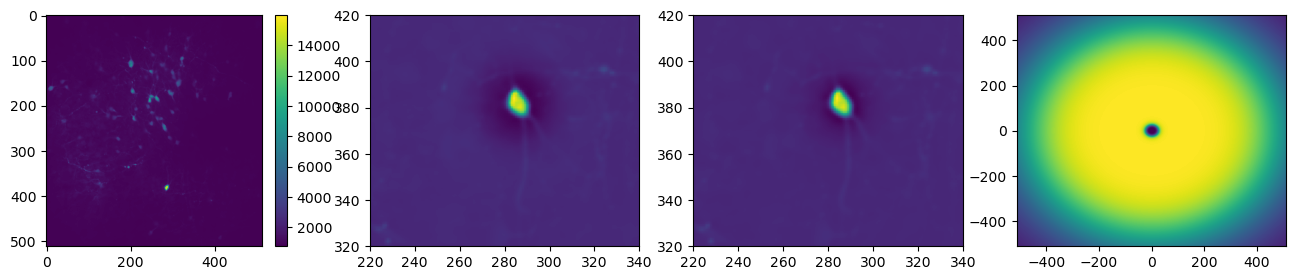

In [413]:
# butterworth filter index
planeIdx = 3

fig,ax = plt.subplots(1,4,figsize=(16,3))
zz = ax[0].imshow(redCell.reference[planeIdx])
ax[0].set_aspect('auto')
plt.colorbar(zz,ax=ax[0])

lowcut = 25
highcut = 500

bwRef, fftImage, bandpass, xfreq, yfreq = bf.butterworthbpf(redCell.reference[planeIdx], lowcut, highcut, order=3, fs=1024, returnFull=True)

yy=ax[1].imshow(bwRef)
ax[1].set_aspect('auto')
ax[1].set_xlim(220,340)
ax[1].set_ylim(320,420)
# plt.colorbar(yy,ax=ax[1])

bwRefAlt = bf.butterworthbpf(redCell.reference[planeIdx], lowcut, highcut, order=1, fs=1024)
xx = ax[2].imshow(bwRefAlt)
ax[2].set_aspect('auto')
ax[2].set_xlim(220,340)
ax[2].set_ylim(320,420)
# plt.colorbar(xx,ax=ax[2])

ax[3].imshow(bandpass, extent=(np.min(xfreq),np.max(xfreq),np.min(yfreq),np.max(yfreq)))
ax[3].set_aspect('auto')

plt.show()